# CALIBRATING of the MODELS

### <span style="color:blue"> Cognition comes by comparison! Friedrich Wilhelm Nietzsche

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
from sklearn.ensemble import BaggingClassifier
from simple_colors import * 
from prettytable import PrettyTable

warnings.filterwarnings("ignore")

%matplotlib inline

df= pd.read_csv('/home/wojciech/Pulpit/1/Stroke_Prediction.csv')
print(df.shape)
print()
print(df.columns)
df.head(3)

(43400, 12)

Index(['ID', 'Gender', 'Age_In_Days', 'Hypertension', 'Heart_Disease',
       'Ever_Married', 'Type_Of_Work', 'Residence', 'Avg_Glucose', 'BMI',
       'Smoking_Status', 'Stroke'],
      dtype='object')


,ID,Gender,Age_In_Days,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke
0,31153,Male,1104.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30650,Male,21204.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,17412,Female,2928.0,0,0,No,Private,Urban,110.89,17.6,NaN,0


Sample reduction:

In [2]:
df = df.sample(frac = 1.00, random_state=10) 
df.shape

(43400, 12)

### Tool for automatic coding of discrete variables 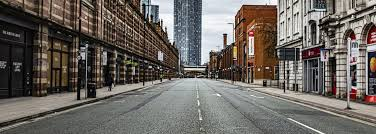


In [3]:
a,b = df.shape     #<- ile mamy kolumn
b

print('DISCRETE FUNCTIONS CODED')
print('------------------------')
for i in range(1,b):
    i = df.columns[i]
    f = df[i].dtypes
    if f == np.object:
        print(i,"---",f)   
    
        if f == np.object:
        
            df[i] = pd.Categorical(df[i]).codes
        
            continue

DISCRETE FUNCTIONS CODED
------------------------
Gender --- object
Ever_Married --- object
Type_Of_Work --- object
Residence --- object
Smoking_Status --- object


In [4]:
df.fillna(7777, inplace=True)

In [5]:
X = df.drop('Stroke', axis=1) 
y = df['Stroke']  

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123,stratify=y)

# Oversampling   !! 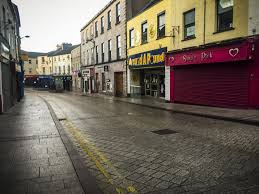

In [6]:
def oversampling(ytrain, Xtrain):
    import matplotlib.pyplot as plt
    
    global Xtrain_OV
    global ytrain_OV

    calss1 = np.round((sum(ytrain == 1)/(sum(ytrain == 0)+sum(ytrain == 1))),decimals=2)*100
    calss0 = np.round((sum(ytrain == 0)/(sum(ytrain == 0)+sum(ytrain == 1))),decimals=2)*100
    
    print("y = 0: ", sum(ytrain == 0),'-------',calss0,'%')
    print("y = 1: ", sum(ytrain == 1),'-------',calss1,'%')
    print('--------------------------------------------------------')
    
    ytrain.value_counts(dropna = False, normalize=True).plot(kind='pie',title='Before oversampling')
    plt.show
    print()
    
    Proporcja = sum(ytrain == 0) / sum(ytrain == 1)
    Proporcja = np.round(Proporcja, decimals=0)
    Proporcja = Proporcja.astype(int)
       
    ytrain_OV = pd.concat([ytrain[ytrain==1]] * Proporcja, axis = 0) 
    Xtrain_OV = pd.concat([Xtrain.loc[ytrain==1, :]] * Proporcja, axis = 0)
    
    ytrain_OV = pd.concat([ytrain, ytrain_OV], axis = 0).reset_index(drop = True)
    Xtrain_OV = pd.concat([Xtrain, Xtrain_OV], axis = 0).reset_index(drop = True)
    
    Xtrain_OV = pd.DataFrame(Xtrain_OV)
    ytrain_OV = pd.DataFrame(ytrain_OV)
    

    
    print("Before oversampling Xtrain:     ", Xtrain.shape)
    print("Before oversampling ytrain:     ", ytrain.shape)
    print('--------------------------------------------------------')
    print("After oversampling Xtrain_OV:  ", Xtrain_OV.shape)
    print("After oversampling ytrain_OV:  ", ytrain_OV.shape)
    print('--------------------------------------------------------')
    
    
    ax = plt.subplot(1, 2, 1)
    ytrain.value_counts(dropna = False, normalize=True).plot(kind='pie',title='Before oversampling')
    plt.show
    
       
    kot = pd.concat([ytrain[ytrain==1]] * Proporcja, axis = 0)
    kot = pd.concat([ytrain, kot], axis = 0).reset_index(drop = True)
    ax = plt.subplot(1, 2, 2)
    kot.value_counts(dropna = False, normalize=True).plot(kind='pie',title='After oversampling')
    plt.show

y = 0:  34094 ------- 98.0 %
y = 1:  626 ------- 2.0 %
--------------------------------------------------------

Before oversampling Xtrain:      (34720, 11)
Before oversampling ytrain:      (34720,)
--------------------------------------------------------
After oversampling Xtrain_OV:   (68524, 11)
After oversampling ytrain_OV:   (68524, 1)
--------------------------------------------------------


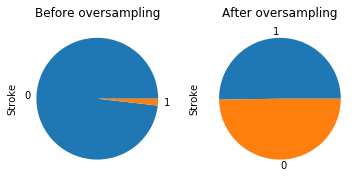

In [7]:
oversampling(y_train, X_train)

I used six models of GaussianNB, LogisticRegression, CatBoostClassifier in their basic version without oversamplin and with oversampling. We will see what differences in the minority set classification the oversampling method gives.!!

I get rid of one dimension from the ytrain_OV set so that the set is similar to y_test.

In [8]:
print(Xtrain_OV.shape)
print(ytrain_OV.shape)
ytrain_OV = ytrain_OV['Stroke']
print(ytrain_OV.shape)

(68524, 11)
(68524, 1)
(68524,)


W poprzednim wpisie uznaliśmy, że oversampling poprawiło jakość klasyfikacji. Kolejne działania będą opierały sie na danych zbilansowanych przez oversampling. Dlatego teraz podmieniamy zwykłą próbę na próbę po oversamoling.

In [9]:
X_train = Xtrain_OV
y_train = ytrain_OV
print(X_train.shape)
print(y_train.shape)

(68524, 11)
(68524,)


## I create 4 groups of classifiers:
1. Normal classifiers after oversampling,
2. Classifiers after bagging
3. Standard calibrators
4. Classifiers after bagging calibrated

### Below are 2 basic groups: 1. Classifiers after oversampling, 2. Classifiers after bagging

In [10]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC 
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier



NBC = GaussianNB()
LRE = LogisticRegression(solver='lbfgs')
GBC = GradientBoostingClassifier()
RFC = RandomForestClassifier()
LGBM = LGBMClassifier() 
CBC = CatBoostClassifier(verbose=0, n_estimators=100)
XGB = XGBClassifier()
LREN = LogisticRegression(solver='newton-cg')
DCF = DecisionTreeClassifier(random_state=0)

classifiers_A = [NBC,LRE,GBC,RFC,LGBM,CBC,XGB,LREN,DCF]
nameA = ['NBC','LRE','GBC','RFC','LGBM','CBC','XGB','LREN','DCF']

### Wzmacnianie przez bagowanie!

NBC_b = BaggingClassifier(base_estimator=NBC, n_estimators=10, max_samples=0.8, max_features=0.8)
LRE_b = BaggingClassifier(base_estimator=LRE, n_estimators=10, max_samples=0.8, max_features=0.8)
GBC_b = BaggingClassifier(base_estimator=GBC, n_estimators=10, max_samples=0.8, max_features=0.8)
RFC_b = BaggingClassifier(base_estimator=RFC, n_estimators=10, max_samples=0.8, max_features=0.8)
LGBM_b = BaggingClassifier(base_estimator=LGBM, n_estimators=10, max_samples=0.8, max_features=0.8)
CBC_b = BaggingClassifier(base_estimator=CBC, n_estimators=10, max_samples=0.8, max_features=0.8)
XGB_b = BaggingClassifier(base_estimator=XGB, n_estimators=10, max_samples=0.8, max_features=0.8)
LREN_b = BaggingClassifier(base_estimator=LREN, n_estimators=10, max_samples=0.8, max_features=0.8)
DCF_b = BaggingClassifier(base_estimator=DCF, n_estimators=10, max_samples=0.8, max_features=0.8)
    
classifiers_B = [NBC_b,LRE_b,GBC_b,RFC_b,LGBM_b,CBC_b,XGB_b,LREN_b,DCF_b]
nameB = ['NBC_b','LRE_b','GBC_b','RFC_b','LGBM_b','CBC_b','XGB_b','LREN_b','DCF_b']
 

## Time is money 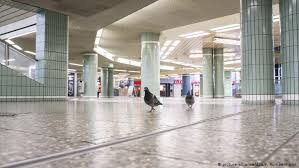

In [11]:
## Pomiar czasu - który model mi opóźnia obliczenia!?
def time_is_money(six_classifiers, name):
    
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve 
    
    print(blue('Time measurement for models in seconds','bold'))
    import time
    timer_P = ['Time for model: ']
    timer_C = ['Time for model calibration: ']
    
    
    def compute(model):
    
        start_time = time.time()
        model.fit(X_train, y_train)
        g =((time.time() - start_time))
        g = np.round(g,decimals=1)
               
        start_time = time.time()
        calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
        calibrated.fit(X_train, y_train)
        c =((time.time() - start_time))
        c = np.round(c,decimals=1)
        
        return g,c
    
    for t,cls in zip(name,six_classifiers):
        results = compute(cls)
        timer_P.append(results[0])
        timer_C.append(results[1])
    
    t = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
    t.add_row(timer_P) 
    t.add_row(timer_C)
    print(t)

In [12]:
time_is_money(classifiers_A,nameA)

Time measurement for models in seconds
+------------------------------+-----+-----+------+------+------+-----+------+------+-----+
|             Name             | NBC | LRE | GBC  | RFC  | LGBM | CBC | XGB  | LREN | DCF |
+------------------------------+-----+-----+------+------+------+-----+------+------+-----+
|       Time for model:        | 0.0 | 0.4 | 11.2 | 8.2  | 0.5  | 1.2 | 2.9  | 10.8 | 0.4 |
| Time for model calibration:  | 0.5 | 2.6 | 48.6 | 35.1 | 3.0  | 6.6 | 11.8 | 37.0 | 1.8 |
+------------------------------+-----+-----+------+------+------+-----+------+------+-----+


## Confusion matrix

In [13]:
def confusion_matrix(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):
    
    from matplotlib import rcParams
    rcParams['axes.titlepad'] = 20 
    
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve 
    from sklearn.metrics import plot_confusion_matrix
    
    for cls in six_classifiers:
        cls.fit(X_train, y_train) 
    
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14,10))
    target_names = ['0','1']


    for t,cls, ax in zip(name, six_classifiers, axes.flatten()):
        plot_confusion_matrix(cls, 
                              X_test, 
                              y_test, 
                              ax=ax, 
                              cmap='Blues',
                             display_labels=target_names,values_format='')
        ax.title.set_text(type(cls).__name__)
        ax.title.set_color('blue')
        ax.text(-0.5, -0.56, t,fontsize=12)
        ax.text(-0.5, 1.40, 'before calibration',color='black', fontsize=10) 
        
    plt.tight_layout()  
    plt.show()
    
### ---------------------------------------------------
    if calibration != True:
        print()
    else:    
        print(blue('Models after calibration','bold'))

    ### ---------------------------------------------------
    
    
        for cls in six_classifiers:
            calibrated = CalibratedClassifierCV(cls, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)
    
        fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14,10))
        target_names = ['0','1']


        for t,cls, ax in zip(name, six_classifiers, axes.flatten()):
            plot_confusion_matrix(cls, 
                                  X_test, 
                                  y_test, 
                                  ax=ax, 
                                  cmap='Blues',
                                 display_labels=target_names,values_format='')
            ax.title.set_text(type(cls).__name__)
            ax.title.set_color('blue')
            ax.text(-0.5, -0.56, t,fontsize=12)
            ax.text(-0.5, 1.40, 'after calibration',color='red', fontsize=10)    ## podtytuł     


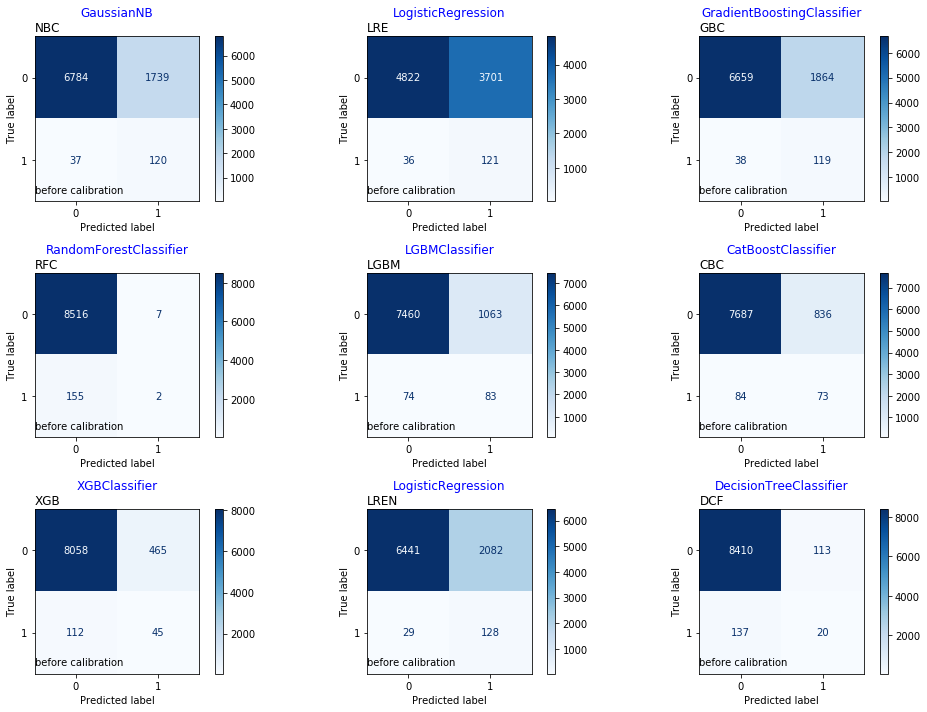

Models after calibration


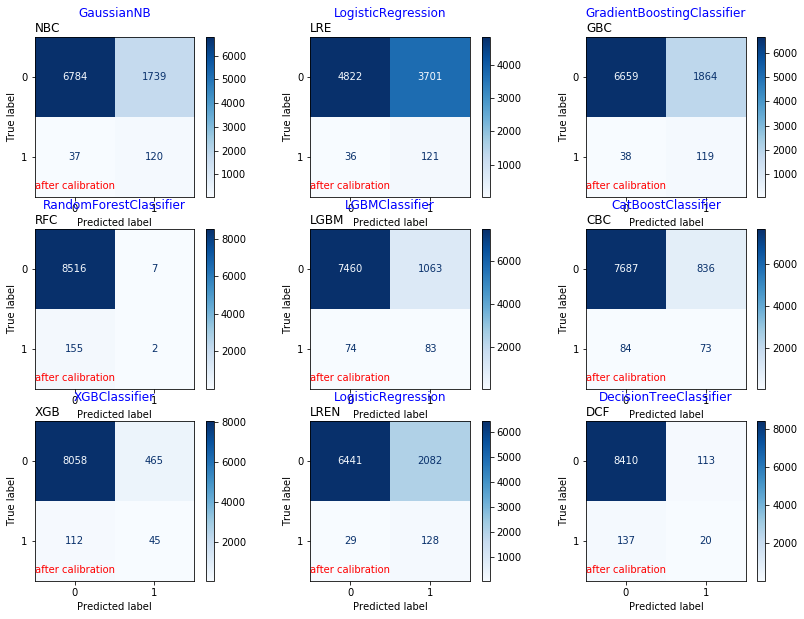

In [14]:
confusion_matrix(classifiers_A,nameA,X_train, y_train,X_test,y_test,calibration=True)

## Recall - Precision!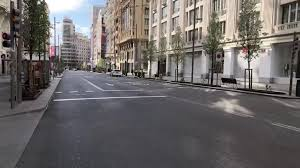

In [15]:
def Recall_Precision(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):

    from sklearn.datasets import make_classification
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve  
    
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn import metrics
    from sklearn.metrics import classification_report, confusion_matrix
    from sklearn.metrics import confusion_matrix, log_loss, auc, roc_curve, roc_auc_score, recall_score, precision_recall_curve
    from sklearn.metrics import make_scorer, precision_score, fbeta_score, f1_score, classification_report
    from sklearn.metrics import accuracy_score
    from mlxtend.plotting import plot_learning_curves
    from prettytable import PrettyTable
    import time   
    
    start_time = time.time()
    
    for cls in six_classifiers:
        cls.fit(X_train, y_train)
      
    
    Recall_Training = ['Recall Training: ']
    Precision_Training = ['Precision Training: ']
    Recall_Test= ['Recall Test: ']
    Precision_Test = ['Precision Test: ']
    
    CAL_Recall_Training = ['CAL_Recall Training: ']
    CAL_Precision_Training = ['CAL_Precision Training: ']
    CAL_Recall_Test= ['CAL_Recall Test: ']
    CAL_Precision_Test = ['CAL_Precision Test: ']   

    def compute_metric2(model):

        Recall_Training = np.round(recall_score(y_train, model.predict(X_train)), decimals=3)
        Precision_Training = np.round(precision_score(y_train, model.predict(X_train)), decimals=3)
        Recall_Test = np.round(recall_score(y_test, model.predict(X_test)), decimals=3) 
        Precision_Test = np.round(precision_score(y_test, model.predict(X_test)), decimals=3)
        
        return Recall_Training, Precision_Training, Recall_Test, Precision_Test
    
    for cls in six_classifiers:

        results = compute_metric2(cls)
        Recall_Training.append(results[0])
        Precision_Training.append(results[1])
        Recall_Test.append(blue(results[2],'bold'))
        Precision_Test.append((blue(results[3],'bold')))
   
    
    t = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
    t.add_row(Recall_Training)
    t.add_row(Precision_Training)
    t.add_row(Recall_Test)
    t.add_row(Precision_Test)

    
    print(blue('Models before calibration','bold'))
    g = (time.time() - start_time)
    g = np.round(g)
    print('time: %s seconds' % g)
    print(t)
    
  ### ---------------------------------------------------------  
    
    
    if calibration != True:
        print()
    else:    
        print(blue('Models after calibration','bold'))

            
        def calibration(model):
        
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)
       
            
        
            CAL_Recall_Training = np.round(recall_score(y_train, calibrated.predict(X_train)), decimals=3)
            CAL_Precision_Training = np.round(precision_score(y_train, calibrated.predict(X_train)), decimals=3)
            CAL_Recall_Test = np.round(recall_score(y_test, calibrated.predict(X_test)), decimals=3) 
            CAL_Precision_Test = np.round(precision_score(y_test, calibrated.predict(X_test)), decimals=3)
        
            return CAL_Recall_Training, CAL_Precision_Training, CAL_Recall_Test, CAL_Precision_Test 
    
        start_time = time.time()
    
        for cls in six_classifiers:

            results = calibration(cls)
            CAL_Recall_Training.append(results[0])
            CAL_Precision_Training.append(results[1])
            CAL_Recall_Test.append(blue(results[2],'bold'))
            CAL_Precision_Test.append((blue(results[3],'bold')))
   
        k = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
        k.add_row(CAL_Recall_Training)
        k.add_row(CAL_Precision_Training)
        k.add_row(CAL_Recall_Test)
        k.add_row(CAL_Precision_Test)   
    
    
        n = (time.time() - start_time)
        n = np.round(n)
        print('time: %s seconds' % n)
        print(k)
    print(blue('Wskaźniki pokazują RECALL i PRECISION dla klasy 1','bold'))
    print(blue('RECALL', 'bold'), blue('procentowy udział chorych dobrze zdiagnozowanych wśród wszystkich ludzi chorych','italic'))
    print(blue('PRECISION', 'bold'), blue('procentowy udział chorych dobrze zdiagnozowanych w populacji ludzi zdiagnozowanych fałszywie (zdrowych uznanych przez model za chorych) i dobrze zdiagnozowanych (chorych uznanych przez model za chorych)','italic'))

In [16]:
Recall_Precision(classifiers_A,nameA,X_train, y_train,X_test,y_test,calibration=True)

Models before calibration
time: 38.0 seconds
+----------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|         Name         |  NBC  |  LRE  |  GBC  |  RFC  |  LGBM |  CBC  |  XGB  |  LREN |  DCF  |
+----------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|  Recall Training:    | 0.762 | 0.791 | 0.874 |  1.0  | 0.994 | 0.998 |  1.0  | 0.818 |  1.0  |
| Precision Training:  | 0.789 | 0.645 |  0.8  |  1.0  | 0.896 | 0.923 | 0.966 | 0.772 |  1.0  |
|    Recall Test:      | 0.764 | 0.771 | 0.758 | 0.013 | 0.529 | 0.465 | 0.287 | 0.815 | 0.127 |
|   Precision Test:    | 0.065 | 0.032 |  0.06 | 0.286 | 0.072 |  0.08 | 0.088 | 0.058 |  0.15 |
+----------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
Models after calibration
time: 161.0 seconds
+--------------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|           Name           |  NBC

## Classification score

In [17]:
def classification_score(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):

    from sklearn.datasets import make_classification
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve   
    from sklearn.metrics import precision_recall_fscore_support as score
    import time   
    
    start_time = time.time()

    Precision_0 = ['Precision_0: ']
    Precision_1 = ['Precision_1: ']
    Recall_0 = ['Recall_0: ']
    Recall_1 = ['Recall_1: ']
    f1_score_0 = ['f1-score_0: ']
    f1_score_1 = ['f1-score_1: ']
    Support_0 = ['Support_0: ']
    Support_1 = ['Support_1: ']
    
    
    CAL_Precision_0 = ['CAL_Precision_0: ']
    CAL_Precision_1 = ['CAL_Precision_1: ']
    CAL_Recall_0 = ['CAL_Recall_0: ']
    CAL_Recall_1 = ['CAL_Recall_1: ']
    CAL_f1_score_0 = ['CAL_f1-score_0: ']
    CAL_f1_score_1 = ['CAL_f1-score_1: ']
    CAL_Support_0 = ['CAL_Support_0: ']
    CAL_Support_1 = ['CAL_Support_1: ']

    for cls in six_classifiers:
        cls.fit(X_train, y_train)
        
    
    def compute_metric4(model):

        precision, recall, fscore, support = score(y_test, model.predict(X_test))
    
        Precision_0 = np.round(precision[:1],decimals=3).item()
        Precision_1 = np.round(precision[1:],decimals=3).item()
        Recall_0 = np.round(recall[:1],decimals=3).item()
        Recall_1 = np.round(recall[1:],decimals=3).item()
        f1_score_0 = np.round(fscore[:1],decimals=3).item()
        f1_score_1 = np.round(fscore[1:],decimals=3).item()
        Support_0 = np.round(support[:1],decimals=3).item()
        Support_1 = np.round(support[1:],decimals=3).item()
        
        return Precision_0, Precision_1, Recall_0, Recall_1, f1_score_0, f1_score_1, Support_0, Support_1

    for cls in six_classifiers:

        results = compute_metric4(cls)
        Precision_0.append(results[0])
        Precision_1.append(blue(results[1],'bold'))
        Recall_0.append(results[2])
        Recall_1.append(blue(results[3],'bold'))
        f1_score_0.append(results[4])
        f1_score_1.append(blue(results[5],'bold'))
        Support_0.append(results[6])
        Support_1.append(blue(results[7],'bold'))
         

    t = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
    t.add_row(Precision_0)
    t.add_row(Precision_1)
    t.add_row(Recall_0)
    t.add_row(Recall_1)
    t.add_row(f1_score_0)
    t.add_row(f1_score_1)
    t.add_row(Support_0)
    t.add_row(Support_1)


    print(blue('Models before calibration','bold'))
    g = (time.time() - start_time)
    g = np.round(g)
    print('time: %s seconds' % g)
    print(t)
    
   ## ------------------------------------------

    if calibration != True:
        print()
    else:    
        print(blue('Models after calibration','bold'))
  
        start_time = time.time()
    
        def calibration(model):
        
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)
            precision, recall, fscore, support = score(y_test, calibrated.predict(X_test))
                
            CAL_Precision_0 = np.round(precision[:1],decimals=3).item()
            CAL_Precision_1 = np.round(precision[1:],decimals=3).item()
            CAL_Recall_0 = np.round(recall[:1],decimals=3).item()
            CAL_Recall_1 = np.round(recall[1:],decimals=3).item()
            CAL_f1_score_0 = np.round(fscore[:1],decimals=3).item()
            CAL_f1_score_1 = np.round(fscore[1:],decimals=3).item()
            CAL_Support_0 = np.round(support[:1],decimals=3).item()
            CAL_Support_1 = np.round(support[1:],decimals=3).item()
        
            return CAL_Precision_0, CAL_Precision_1, CAL_Recall_0, CAL_Recall_1, CAL_f1_score_0, CAL_f1_score_1, CAL_Support_0, CAL_Support_1
    
        for cls in six_classifiers:

            results = calibration(cls)
            CAL_Precision_0.append(results[0])
            CAL_Precision_1.append(blue(results[1],'bold'))
            CAL_Recall_0.append(results[2])
            CAL_Recall_1.append(blue(results[3],'bold'))
            CAL_f1_score_0.append(results[4])
            CAL_f1_score_1.append(blue(results[5],'bold'))
            CAL_Support_0.append(results[6])
            CAL_Support_1.append(blue(results[7],'bold'))
   
        k = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
        k.add_row(CAL_Precision_0)
        k.add_row(CAL_Precision_1)
        k.add_row(CAL_Recall_0)
        k.add_row(CAL_Recall_1)
        k.add_row(CAL_f1_score_0)
        k.add_row(CAL_f1_score_1)
        k.add_row(CAL_Support_0)
        k.add_row(CAL_Support_1)
    
        n = (time.time() - start_time)
        n = np.round(n)
        print('time: %s seconds' % n)
        print(k)
    print(blue('RECALL', 'bold'), blue('procentowy udział chorych dobrze zdiagnozowanych wśród wszystkich ludzi chorych','italic'))
    print(blue('PRECISION', 'bold'), blue('procentowy udział chorych dobrze zdiagnozowanych w populacji ludzi zdiagnozowanych fałszywie (zdrowych uznanych przez model za chorych) i dobrze zdiagnozowanych (chorych uznanych przez model za chorych)','italic')) 
    

In [18]:
classification_score(classifiers_A,nameA,X_train, y_train,X_test,y_test,calibration=True)

Models before calibration
time: 33.0 seconds
+---------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|      Name     |  NBC  |  LRE  |  GBC  |  RFC  |  LGBM |  CBC  |  XGB  |  LREN |  DCF  |
+---------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| Precision_0:  | 0.995 | 0.993 | 0.994 | 0.982 |  0.99 | 0.989 | 0.986 | 0.996 | 0.984 |
| Precision_1:  | 0.065 | 0.032 |  0.06 | 0.556 | 0.072 |  0.08 | 0.088 | 0.058 |  0.15 |
|   Recall_0:   | 0.796 | 0.566 | 0.781 |  1.0  | 0.875 | 0.902 | 0.945 | 0.756 | 0.987 |
|   Recall_1:   | 0.764 | 0.771 | 0.758 | 0.032 | 0.529 | 0.465 | 0.287 | 0.815 | 0.127 |
|  f1-score_0:  | 0.884 | 0.721 | 0.875 | 0.991 | 0.929 | 0.944 | 0.965 | 0.859 | 0.985 |
|  f1-score_1:  | 0.119 | 0.061 | 0.111 |  0.06 | 0.127 | 0.137 | 0.135 | 0.108 | 0.138 |
|  Support_0:   |  8523 |  8523 |  8523 |  8523 |  8523 |  8523 |  8523 |  8523 |  8523 |
|  Support_1:   |  157  |  157  |  157  |  157  |  157 

## Type error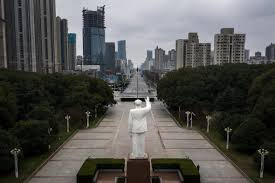

In [19]:
def Type_error(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):

    
    from sklearn.datasets import make_classification
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve
    from sklearn.metrics import confusion_matrix
    
    from sklearn import metrics
    import simple_colors
    import time   
    
    start_time = time.time()
    
    for cls in six_classifiers:
        cls.fit(X_train, y_train)    
    
    FPR = ['False_Positive_Rate:']
    TPR = ['True_Positive_Rate: ']
    FNR = ['False_Negative_Rate: ']
    SPEC = ['Specifity']
    
    CAL_FPR = ['CAL_False_Positive_Rate:']
    CAL_TPR = ['CAL_True_Positive_Rate: ']
    CAL_FNR = ['CAL_False_Negative_Rate: ']
    CAL_SPEC = ['CAL_Specifity']

    def compute_metric(model):
        
        
        model = model.fit(X_train,y_train)
        cm = confusion_matrix(y_test, model.predict(X_test))
        tn, fp, fn, tp = cm.ravel()
        # print('tn: ',tn)
        # print('fp: ',fp)
        # print('fn: ',fn)
        # print('tp: ',tp)
        # print('------------------')
        # print(cm) 
        

        FPR = np.round(fp/(fp + tn),decimals=3)
        TPR = np.round(tp/(tp + fn),decimals=3)
        FNR = np.round(fn/(tp + fn),decimals=3)
        SPEC = np.round(tn/(tn + fp),decimals=3)

        return FPR,TPR,FNR,SPEC

    for cls in six_classifiers:      
        
        results = compute_metric(cls)
        FPR.append(red(results[0],'bold'))
        TPR.append(red(results[1],'bold'))
        FNR.append(results[2])
        SPEC.append(results[3])

    t = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
    t.add_row(FPR)
    t.add_row(TPR)
    t.add_row(FNR)
    t.add_row(SPEC)

    print(blue('Models before calibration','bold'))
    g = (time.time() - start_time)
    g = np.round(g)
    print('time: %s seconds' % g)
    print(t)
  ## --------------------------------------------------  
    
    if calibration != True:
        print()
    else:    
        print(blue('Models after calibration','bold'))
  
        start_time = time.time()
    
        def calibration(model):
        
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)
        
            ck = confusion_matrix(y_test, calibrated.predict(X_test))
            tn_c, fp_c, fn_c, tp_c = ck.ravel()
            # print('tn: ',tn)
            # print('fp: ',fp)
            # print('fn: ',fn)
            # print('tp: ',tp)
            # print('------------------')
            # print(cm) 
        

            CAL_FPR = np.round(fp_c/(fp_c + tn_c),decimals=3)
            CAL_TPR = np.round(tp_c/(tp_c + fn_c),decimals=3)
            CAL_FNR = np.round(fn_c/(tp_c + fn_c),decimals=3)
            CAL_SPEC = np.round(tn_c/(tn_c + fp_c),decimals=3)

            return CAL_FPR, CAL_TPR, CAL_FNR, CAL_SPEC

        for cls in six_classifiers:      
        
            results = calibration(cls)
            CAL_FPR.append(red(results[0],'bold'))
            CAL_TPR.append(red(results[1],'bold'))
            CAL_FNR.append(results[2])
            CAL_SPEC.append(results[3])

        k = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
        k.add_row(CAL_FPR)
        k.add_row(CAL_TPR)
        k.add_row(CAL_FNR)
        k.add_row(CAL_SPEC)
    
    
        n = (time.time() - start_time)
        n = np.round(n)
        print('time: %s seconds' % n)
        print(k)
    
    
    print(red('False_Positive_Rate','bold'),red('procentowy udział ludzi zdrowych uznanych przez model za chorych w populacji ludzi zdrowych','italic'))
    print(red('True_Positive_Rate RECALL','bold'), red('procentowy udział chorych dobrze zdiagnozowanych w populacji ludzi chorych ogółem','italic'))
    print(black('False_Negative_Rate','bold'), black('procentowy udział niewykrytych chorych w populacji ludzi chorych ogółem','italic'))
    print(black('Specifity','bold'), black('procentowy udział ludzi zdrowych uznanych za zdrowych w populacji ludzi zdrowych','italic'))

In [20]:
Type_error(classifiers_A,nameA,X_train, y_train,X_test,y_test,calibration=True)

Models before calibration
time: 66.0 seconds
+-----------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|          Name         |  NBC  |  LRE  |  GBC  |  RFC  |  LGBM |  CBC  |  XGB  |  LREN |  DCF  |
+-----------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|  False_Positive_Rate: | 0.204 | 0.434 | 0.219 |  0.0  | 0.125 | 0.098 | 0.055 | 0.244 | 0.013 |
|  True_Positive_Rate:  | 0.764 | 0.771 | 0.758 | 0.013 | 0.529 | 0.465 | 0.287 | 0.815 | 0.127 |
| False_Negative_Rate:  | 0.236 | 0.229 | 0.242 | 0.987 | 0.471 | 0.535 | 0.713 | 0.185 | 0.873 |
|       Specifity       | 0.796 | 0.566 | 0.781 |  1.0  | 0.875 | 0.902 | 0.945 | 0.756 | 0.987 |
+-----------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
Models after calibration
time: 142.0 seconds
+---------------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|            Name       

## AUC score

In [21]:
def AUC_score(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):
    
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve
    from sklearn import metrics
    import time   
    
    start_time = time.time()

    for cls in six_classifiers:
        cls.fit(X_train, y_train)    
    
    AUC_train = ['AUC_train: ']
    AUC_test = ['AUC_test: ']
    CAL_AUC_train = ['AUC_train: ']
    CAL_AUC_test = ['AUC_test: ']
    
    
    def compute_metric(model):

        auc_train = np.round(metrics.roc_auc_score(y_train,model.predict_proba(X_train)[:,1]),decimals=3)
        auc_test = np.round(metrics.roc_auc_score(y_test,model.predict_proba(X_test)[:,1]),decimals=3)

        return auc_train, auc_test

    for cls in six_classifiers:

        results = compute_metric(cls)
        AUC_train.append(results[0])
        AUC_test.append(blue(results[1],'bold'))


    t = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
    t.add_row(AUC_train)
    t.add_row(AUC_test)
    
    
    print(blue('Models before calibration','bold'))
    g = (time.time() - start_time)
    g = np.round(g)
    print('time: %s secondS' % g)
    print(t)
    
    if calibration != True:
        print()
    else:    
        print(blue('Models after calibration','bold'))
    
        start_time = time.time()
    
        def calibration(model):
        
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)
         
            CAL_AUC_train = np.round(metrics.roc_auc_score(y_train,calibrated.predict_proba(X_train)[:,1]),decimals=3)
            CAL_AUC_test = np.round(metrics.roc_auc_score(y_test,calibrated.predict_proba(X_test)[:,1]),decimals=3)

            return CAL_AUC_train, CAL_AUC_test

    
        for cls in six_classifiers:

            results = calibration(cls)
            CAL_AUC_train.append(results[0])
            CAL_AUC_test.append(blue(results[1],'bold'))
       
   
        k = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
        k.add_row(CAL_AUC_train)
        k.add_row(CAL_AUC_test)
    
        n = (time.time() - start_time)
        n = np.round(n)
        print('time: %s seconds' % n)    
        print(k)
    

In [22]:
AUC_score(classifiers_A,nameA,X_train, y_train,X_test,y_test,calibration=True)

Models before calibration
time: 35.0 secondS
+-------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|     Name    |  NBC  |  LRE  |  GBC  |  RFC  |  LGBM |  CBC  |  XGB  |  LREN |  DCF  |
+-------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| AUC_train:  | 0.849 | 0.756 | 0.909 |  1.0  | 0.985 | 0.989 | 0.999 | 0.867 |  1.0  |
|  AUC_test:  | 0.853 |  0.75 | 0.852 | 0.828 | 0.832 | 0.804 | 0.803 | 0.861 | 0.557 |
+-------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
Models after calibration
time: 148.0 seconds
+-------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|     Name    |  NBC  |  LRE  |  GBC  |  RFC  |  LGBM |  CBC  |  XGB  |  LREN |  DCF  |
+-------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| AUC_train:  | 0.849 | 0.773 |  0.91 |  1.0  | 0.991 | 0.995 |  1.0  | 0.867 |  1.0  |
|  AUC_test:  | 0.853 | 0.767 

## Binary Classficators Plots  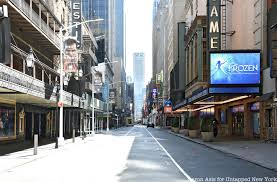

In [23]:
def BinaryClassPlot(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=False):
    
    import time
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve
    from matplotlib import rcParams      ## Robie odstęp na podtytuł
    rcParams['axes.titlepad'] = 20 
    
    start_time = time.time()
    
    from plot_metric.functions import BinaryClassification

    for cls in six_classifiers:
        cls.fit(X_train, y_train) 
       
    plt.figure(figsize=(15,10))
    grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.5)
        
    for i in range(9):
        col, row = i%3,i//3
        ax = plt.subplot(grid[row,col]) 
        ax.title.set_color('blue')
            
        model = six_classifiers[i]
        bc = BinaryClassification(y_test, model.predict_proba(X_test)[:,1], labels=["Class 1", "Class 2"])
        bc.plot_roc_curve(title=type(six_classifiers[i]).__name__)
        ax.text(0.0, 1.09, 'before calibration',color='black', fontsize=10) 
        ax.text(0.5, 1.09, name[i],fontsize=10)    ## podtytuł

 ### ------------------------------------------------------------------------------       
    if calibration != True:
        print()
    else:    
           
        #for cls in six_classifiers:
        #    cls.fit(X_train, y_train)
                            
        plt.figure(figsize=(15,10))
        grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.5)

        for i in range(9):
            col, row = i%3,i//3
            ax = plt.subplot(grid[row,col]) 
            ax.title.set_color('blue')
            
            model = six_classifiers[i]
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)        
                
            bc = BinaryClassification(y_test, calibrated.predict_proba(X_test)[:,1], labels=["Class 1", "Class 2"])
            bc.plot_roc_curve(title=type(six_classifiers[i]).__name__)
            ax.text(0.0, 1.09, 'after calibration',color='red', fontsize=10)    ## podtytuł     
            ax.text(0.5, 1.09, name[i],fontsize=10)    ## podtytuł   
        
        
        n = (time.time() - start_time)
        n = np.round(n)
        print('time: %s seconds' % n)    

time: 174.0 seconds


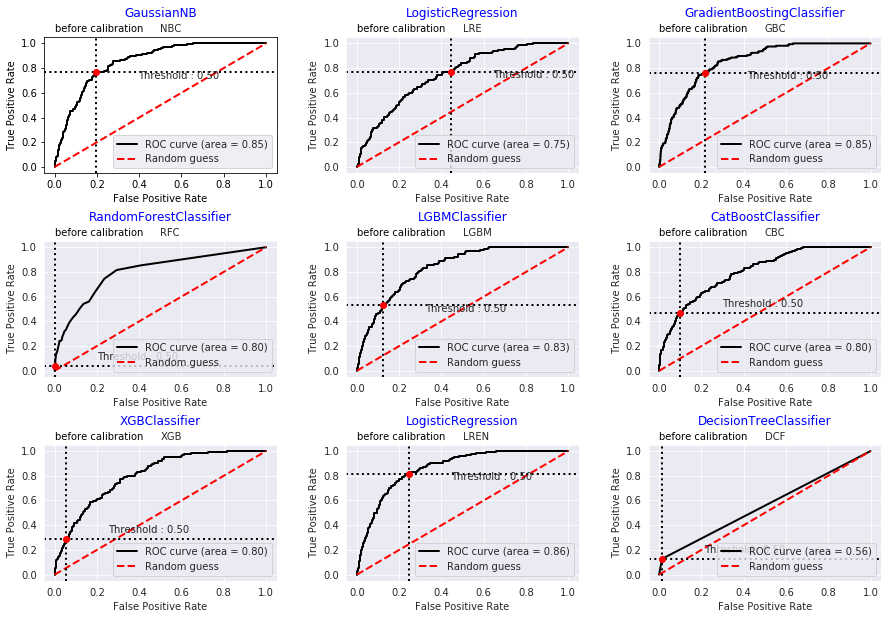

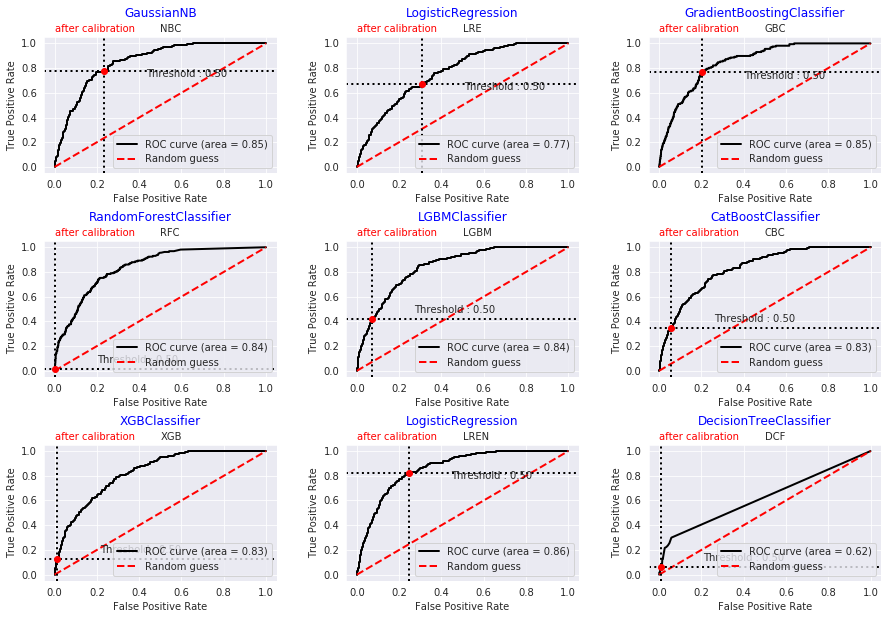

In [24]:
BinaryClassPlot(classifiers_A,nameA,X_train, y_train,X_test,y_test,calibration=True)

## ROC AUC plots

In [25]:
def plot_roc(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):
    
    import time
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve
    from matplotlib import rcParams      ## Robie odstęp na podtytuł
    rcParams['axes.titlepad'] = 20 
    
    import scikitplot as skplt
    
    start_time = time.time()
    
    plt.figure(figsize=(15,10))
    grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.5)

    for cls in six_classifiers:
        cls.fit(X_train, y_train)

    for i in range(9):

        col, row = i%3,i//3
        ax = plt.subplot(grid[row,col]) 
        ax.title.set_color('blue')

        model = classifiers_A[i]
        skplt.metrics.plot_roc(y_test, model.predict_proba(X_test), ax=ax, title=type(six_classifiers[i]).__name__)
        ax.text(0.5, 1.09, name[i],fontsize=10)    ## podtytuł
        ax.text(0.0, 1.09, 'before calibration',color='black', fontsize=10)
## ---------------------------------------------------------------------------------------------------
    
    if calibration != True:
        print()
    else:    
    
    
        plt.figure(figsize=(15,10))
        grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.5)
    
    
        for cls in six_classifiers:
            cls.fit(X_train, y_train)

        for i in range(9):

            col, row = i%3,i//3
            ax = plt.subplot(grid[row,col]) 
            ax.title.set_color('blue')

            model = classifiers_A[i]
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)        
        
            skplt.metrics.plot_roc(y_test, calibrated.predict_proba(X_test), ax=ax, title=type(six_classifiers[i]).__name__)
            ax.text(0.5, 1.09, name[i],fontsize=10)    ## podtytuł
            ax.text(0.0, 1.09, 'after calibration',color='red', fontsize=10)    ## podtytuł  
    
    n = (time.time() - start_time)
    n = np.round(n)
    print('time: %s seconds' % n)    

time: 207.0 seconds


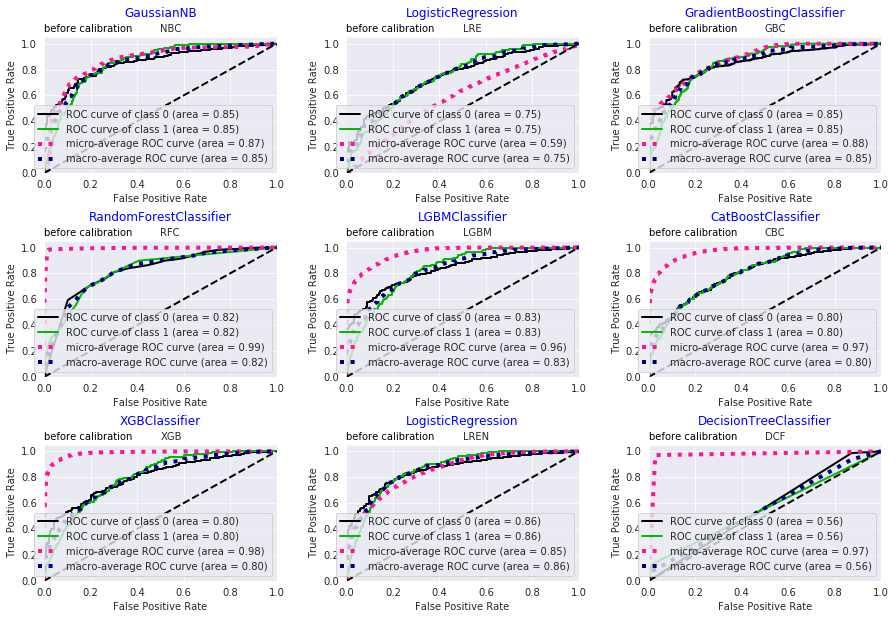

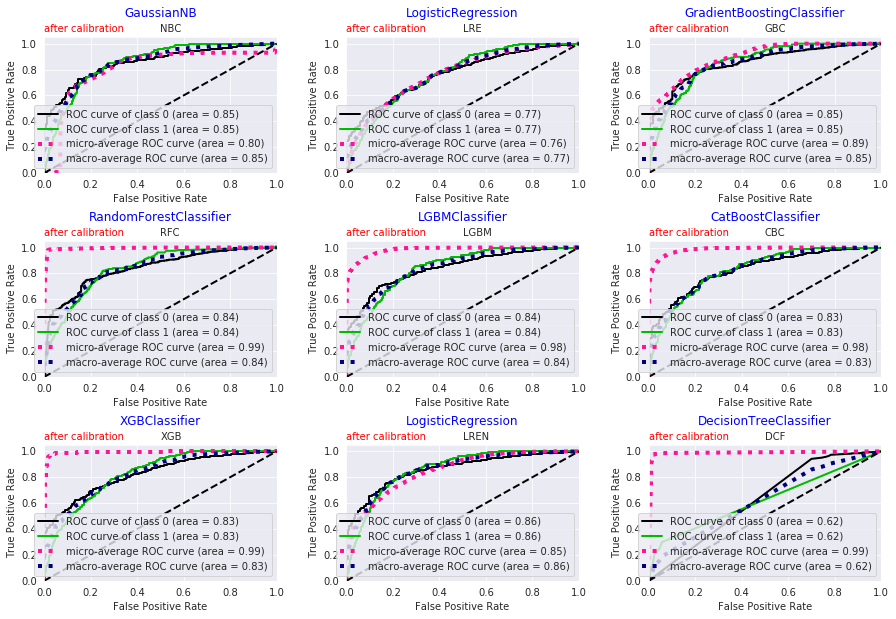

In [26]:
plot_roc(classifiers_A,nameA,X_train, y_train,X_test,y_test,calibration=True)

W tym teście szczególnie waża jest różnica pomiedzy <span style="background:#ff00ff"> krzywą micro-average ROC pokazaną na różowo</span> oraz <span style="color:#0000ff"> krzywą macro-average ROC pokazana na granatowo</span>.
Idealnie gdy obie krzywe się pokrywają. Zbilansowanie klas prze oversampling poprawiło w wielu medelach spójność obu krzywych, w niektórych jednak pozostały duże różnice.

Jeżeli: 

<span style="font-size: 150%;color:#0000ff">macro average ROC</span><span style="font-size: 250%"> > </span> <span style="font-size: 150%;background:#ff00ff">micro average ROC</span> 
wtedy mówimy, że: "1 (minority) is better classified than 0 (majority) - macro > micro"

Jeżeli:

<span style="font-size: 150%;color:#0000ff">macro average ROC</span><span style="font-size: 250%"> < </span> <span style="font-size: 150%;background:#ff00ff">micro average ROC</span> 
wtedy mówimy, że: '0 (majority) is better classified than 1 (minority)- micro < macro'


Idealnie gdy krzywe micro i macro pokrywają się ze sobą. Taka sytuacja ma miejsce po oversampling w GaussianNB oraz GradientBoostingClassifier.


In [27]:
def calibration_curve2(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=False):
    
    from matplotlib import rcParams      ## Robie odstęp na podtytuł
    rcParams['axes.titlepad'] = 20 
    
    import scikitplot as skplt
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve
    
    plt.figure(figsize=(15,10))
    grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.5)

    for cls in six_classifiers:
        cls.fit(X_train, y_train)

    for i in range(9):

        col, row = i%3,i//3
        ax = plt.subplot(grid[row,col])
        ax.title.set_color('blue')
           
        model = classifiers_A[i]
        A_probas = model.fit(X_train, y_train).predict_proba(X_test)
        probas_list = [A_probas]
        
        clf_names =  [name[i]]
        
        skplt.metrics.plot_calibration_curve(y_test,probas_list,clf_names,title=type(six_classifiers[i]).__name__,ax=ax)  
        ax.text(0.5, 1.09, name[i],fontsize=10)    ## podtytuł
        ax.text(0.0, 1.09, 'before calibration',color='black', fontsize=10)
   ### -----------------------------------------------------------------------------------

    if calibration != True:
        print()
    else:   
        plt.figure(figsize=(15,10))
        grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.5)

        for cls in six_classifiers:
            cls.fit(X_train, y_train)

        for i in range(9):

            col, row = i%3,i//3
            ax = plt.subplot(grid[row,col])
            ax.title.set_color('blue')

            model = classifiers_A[i]
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train) 
        
            A_probas = calibrated.fit(X_train, y_train).predict_proba(X_test)
            probas_list = [A_probas]
        
            clf_names =  [name[i]]
        
            skplt.metrics.plot_calibration_curve(y_test,probas_list,clf_names,title=type(six_classifiers[i]).__name__,ax=ax)  
            ax.text(0.5, 1.09, name[i],fontsize=10)    ## podtytuł
            ax.text(0.0, 1.09, 'after calibration',color='red', fontsize=10)    ## podtytuł 

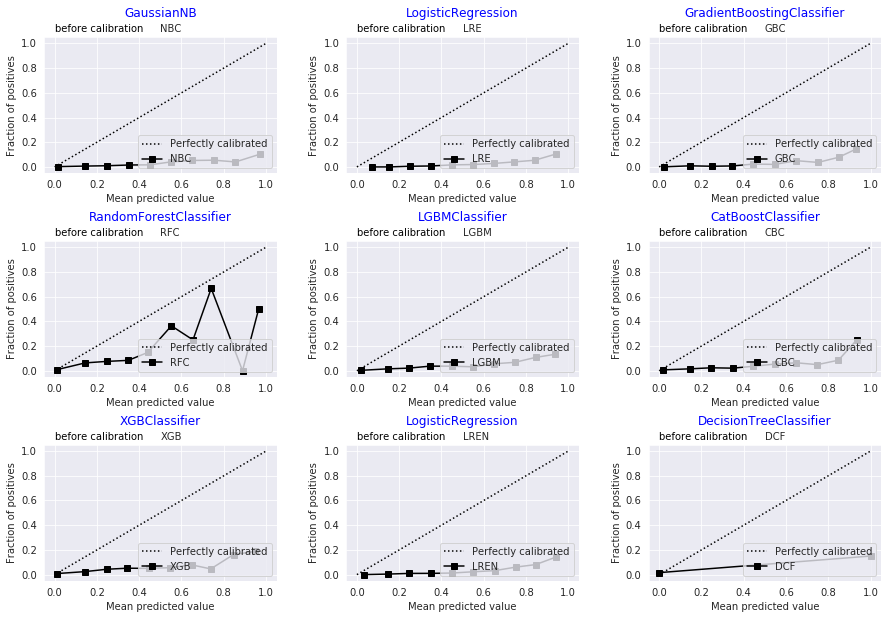

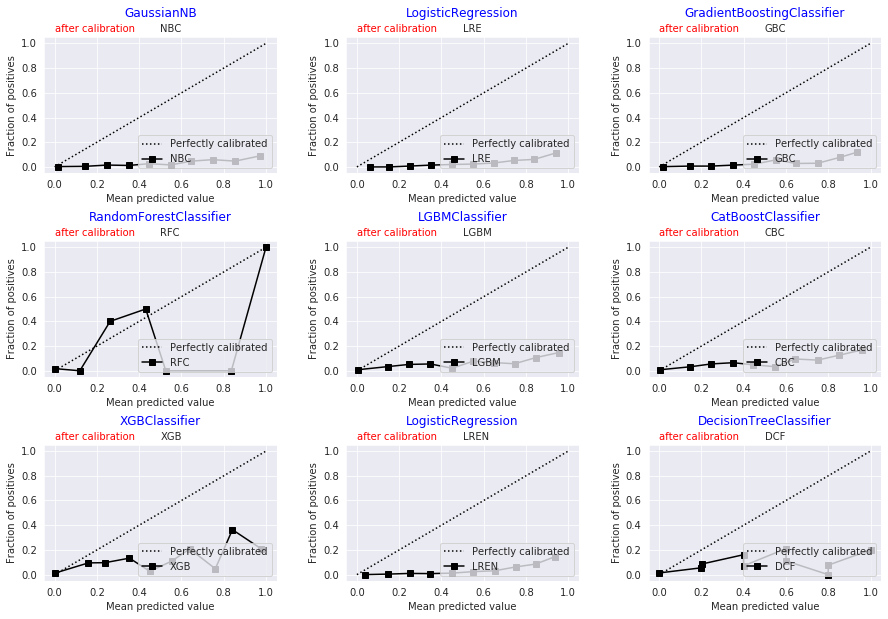

In [28]:
calibration_curve2(classifiers_A,nameA,X_train, y_train,X_test,y_test,calibration=True)


## Cohen Kappa Metric

<font size="3"> 
$ \bbox[20px,border:1px solid red]
{
 κ = \displaystyle\frac{(p_o - p_e)}{(1 - p_e)}=1-\frac{1 - p_e}{1 - p_e}
\qquad   
} $


where: 

$ p_0 = \displaystyle\frac{(tn+𝑡𝑝)}{(tn+fp+fn+𝑡𝑝)}$

$ p_{empire} = \displaystyle\frac{(tn+fp)}{(tn+fp+fn+𝑡𝑝)}\times\frac{(tn+fn)}{(tn+fp+fn+𝑡𝑝)}$

$ p_{theory} = \displaystyle\frac{(fn+𝑡𝑝)}{(tn+fp+fn+𝑡𝑝)}\times\frac{(fp+𝑡𝑝)}{(tn+fp+fn+𝑡𝑝)}$


$ p_e = p_{empire}+p_{theory}$



In [29]:
def Cohen_Kappa(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=False):
    
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve
    from sklearn import metrics
    import simple_colors
    import time   
    
    start_time = time.time()
    
    κ = ['κ:']
    p0 = ['p0:']
    pe = ['pe:']
    
    κc = ['κ:']
    p0c = ['p0:']
    pec = ['pe:']    
    
    
    
    for cls in six_classifiers:
        cls.fit(X_train, y_train)    
    
    def compute_metric(model):
        
        from sklearn.metrics import confusion_matrix

        model.fit(X_train,y_train)
        cm = confusion_matrix(y_test, model.predict(X_test))
        tn, fp, fn, tp = cm.ravel()     
        
        p0 = (tn+𝑡𝑝)/(tn+fp+fn+𝑡𝑝)
        P_empire = ((tn+fp)/(tn+fp+fn+𝑡𝑝))*((tn+fn)/(tn+fp+fn+𝑡𝑝))
        P_theory = ((fn+𝑡𝑝)/(tn+fp+fn+𝑡𝑝))*((fp+𝑡𝑝)/(tn+fp+fn+𝑡𝑝))
        pe = P_empire + P_theory
        κ = (p0-pe)/(1-pe)
        
        κ = np.round(κ,decimals=3)
        p0 = np.round(p0,decimals=3)
        pe = np.round(pe,decimals=3)
        
        return κ,p0, pe

    for cls in six_classifiers:
        
        results = compute_metric(cls)
        κ.append(blue(results[0],'bold'))
        p0.append(results[1])
        pe.append(results[2])
      

    t = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
    t.add_row(p0)
    t.add_row(pe)
    t.add_row(κ)

    print(blue('Models before calibration','bold'))
    g = (time.time() - start_time)
    g = np.round(g)
    print('time: %s second' % g)
    print(t)   
    print()
  ###------------------------------------------------------------  
    
    if calibration != True:
        print()
    else:   
        print(blue('Models after calibration','bold'))
        
        plt.figure(figsize=(15,10))
        grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.5)
        
        start_time = time.time()
    
        def compute_metric2(model):
            
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)     
            
            calibrated = calibrated.fit(X_train,y_train)
            cm = confusion_matrix(y_test, calibrated.predict(X_test))
            tn, fp, fn, tp = cm.ravel()
   
        
            p0c = (tn+𝑡𝑝)/(tn+fp+fn+𝑡𝑝)
            P_empire = ((tn+fp)/(tn+fp+fn+𝑡𝑝))*((tn+fn)/(tn+fp+fn+𝑡𝑝))
            P_theory = ((fn+𝑡𝑝)/(tn+fp+fn+𝑡𝑝))*((fp+𝑡𝑝)/(tn+fp+fn+𝑡𝑝))
            pec = P_empire + P_theory
            κc = (p0c-pec)/(1-pec)
        
            κc = np.round(κc,decimals=3)
            p0c = np.round(p0c,decimals=3)
            pec = np.round(pec,decimals=3)
        
            return κc,p0c, pec

        for cls in six_classifiers:
        
            results = compute_metric2(cls)
            κc.append(blue(results[0],'bold'))
            p0c.append(results[1])
            pec.append(results[2])
      

        k = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
        k.add_row(p0c)
        k.add_row(pec)
        k.add_row(κc)

        n = (time.time() - start_time)
        n = np.round(n)
        print('time: %s second' % n)         
        print(k)
    
    print(blue('Obserwowana zgodność p0', 'underlined'))
    print(black('Jest to prawdopodobieństwo dobrego wyboru, to procent przypadków, które zostały sklasyfikowane prawidłowo w całej matrycy zamieszania, czyli prawdziwi chorzy zostali sklasyfikowani jako chorzy a prawdziwie zdrowi sklasyfikowani jako prawdziwie zdrowi','italic'))
    print(blue('Oczekiwana zgodność pe', 'underlined'))
    print(black('Jest to prawdopodobieństwo wyboru bezpośrednio związana z liczbą wystąpień każdej klasy. Jeżeli wystąpień klas było po równo (np. 1: 20 wystąpień i 0: 20 wystapień), czyli zbiór był zbilansowany, to prawdopodobieństwo wynosi 50%. ','italic'))
    print(blue('Cohen Kappa mówi, o ile lepszy jest model klasyfikacji (p0) od losowego klasyfikatora(pe), który przewiduje na podstawie częstotliwości klas.','italic'))
    print(black(''))
    print(black('Statystyka może być ujemna, co oznacza, że nie ma skutecznej zgodności między dwoma wskaźnikami lub zgodność jest gorsza niż losowa.'))

In [30]:
Cohen_Kappa(classifiers_A,nameA, X_train, y_train,X_test,y_test,calibration=False)

Models before calibration
time: 67.0 second
+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| Name |  NBC  |  LRE  |  GBC  |  RFC  |  LGBM |  CBC  |  XGB  |  LREN |  DCF  |
+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| p0:  | 0.795 | 0.569 | 0.781 | 0.982 | 0.869 | 0.894 | 0.934 | 0.757 | 0.971 |
| pe:  | 0.775 | 0.558 | 0.762 | 0.981 | 0.855 | 0.881 | 0.925 | 0.737 | 0.967 |
|  κ:  | 0.089 | 0.027 |  0.08 | 0.034 | 0.099 | 0.109 |  0.11 | 0.077 | 0.123 |
+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+


Obserwowana zgodność p0
Jest to prawdopodobieństwo dobrego wyboru, to procent przypadków, które zostały sklasyfikowane prawidłowo w całej matrycy zamieszania, czyli prawdziwi chorzy zostali sklasyfikowani jako chorzy a prawdziwie zdrowi sklasyfikowani jako prawdziwie zdrowi
Oczekiwana zgodność pe
Jest to prawdopodobieństwo wyboru bezpośrednio związana z liczbą wystąpień każdej klasy. 

# Matthews Correlation Coefficient MCC  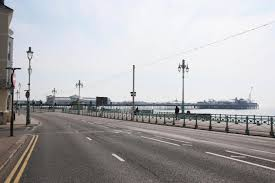

The Matthews Correlation Coefficient (MCC) has a range of -1 to 1, where -1 is a completely bad binary classifier and 1 is a completely valid binary classifier.


<font size="3"> 
$ \bbox[23px,border:1px solid red]
{
 MCC = \displaystyle\frac{{(tp \times tn)}-{(fp \times fn)}}{(tp+fp)(tp+fn)(tn+fp)(tn+fn)}
\qquad   
} $

In [31]:
def MCC(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):
    
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve
    import time   
    
    start_time = time.time()
    
    from sklearn import metrics
    import simple_colors
    
    for cls in six_classifiers:
        cls.fit(X_train, y_train)    
    
    
    MCC = ['MCC:']
    
    def compute_metric(model):
        
        from sklearn.metrics import confusion_matrix

        model.fit(X_train,y_train)
        cm = confusion_matrix(y_test, model.predict(X_test))
        tn, fp, fn, tp = cm.ravel()     
        
        MCC = ((tp*tn)-(fp*fn))/(((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))** .5)
        MCC = np.round(MCC,decimals=3)
        MCC
        
        return MCC

    for cls in six_classifiers:
        
        results = compute_metric(cls)
        MCC.append(results)
             

    t = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
    t.add_row(MCC)
    
    print('Matthews Correlation Coefficient MCC')
        
    ### ---------------------------------------------------
    
    print(blue('Models before calibration','bold'))
    g = (time.time() - start_time)
    g = np.round(g)
    print('time: %s seconds' % g)
    print(t)
    
    ### ---------------------------------------------------
        
    if calibration != True:
        print()
    else:   
        print(blue('Models after calibration','bold'))

   

        start_time = time.time()
    
        from sklearn import metrics
        import simple_colors
    
        for cls in six_classifiers:
            cls.fit(X_train, y_train)    
    
    
        MCC = ['MCC:']
    
        def compute_metric(model):
        
            from sklearn.metrics import confusion_matrix

            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)    
            cm = confusion_matrix(y_test, calibrated.predict(X_test))
            tn, fp, fn, tp = cm.ravel()     
        
            MCC = ((tp*tn)-(fp*fn))/(((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))** .5)
            MCC = np.round(MCC,decimals=3)
            MCC
        
            return MCC

        for cls in six_classifiers:
        
            results = compute_metric(cls)
            MCC.append(results)
             

        k = PrettyTable(['Name', name[0],name[1],name[2],name[3],name[4],name[5],name[6],name[7],name[8]])
        k.add_row(MCC)
    
        n = (time.time() - start_time)
        n = np.round(n)
        print('time: %s seconds' % n)         
        print(k)
    
       
    print(black('Współczynnik korelacji Matthewsa (MCC) ma zakres od -1 do 1, gdzie -1 oznacza całkowicie zły klasyfikator binarny, a 1 oznacza całkowicie poprawny klasyfikator binarny','italic'))
    

In [32]:
MCC(classifiers_A,nameA, X_train, y_train,X_test,y_test,calibration=True)

Matthews Correlation Coefficient MCC
Models before calibration
time: 66.0 seconds
+------+-------+------+-------+-------+-------+------+-------+-------+-------+
| Name |  NBC  | LRE  |  GBC  |  RFC  |  LGBM | CBC  |  XGB  |  LREN |  DCF  |
+------+-------+------+-------+-------+-------+------+-------+-------+-------+
| MCC: | 0.182 | 0.09 | 0.171 | 0.076 | 0.159 | 0.16 | 0.132 | 0.175 | 0.124 |
+------+-------+------+-------+-------+-------+------+-------+-------+-------+
Models after calibration
time: 172.0 seconds
+------+-------+-------+-------+-------+------+-------+-------+-------+------+
| Name |  NBC  |  LRE  |  GBC  |  RFC  | LGBM |  CBC  |  XGB  |  LREN | DCF  |
+------+-------+-------+-------+-------+------+-------+-------+-------+------+
| MCC: | 0.166 | 0.103 | 0.181 | 0.055 | 0.17 | 0.159 | 0.126 | 0.176 | 0.08 |
+------+-------+-------+-------+-------+------+-------+-------+-------+------+
Współczynnik korelacji Matthewsa (MCC) ma zakres od -1 do 1, gdzie -1 oznacza całko

https://en.wikipedia.org/wiki/Cohen%27s_kappa

## Trainsize

In [33]:
def Trainsize(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):
    
    import time
    from mlxtend.plotting import plot_learning_curves
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve
    
    start_time = time.time()
    
    for cls in six_classifiers:
        cls.fit(X_train, y_train) 
        
    plt.figure(figsize=(15,7))

    grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.4)

    for i in range(9):
        col, row = i%3,i//3
        ax = plt.subplot(grid[row,col]) 
        ax.title.set_text(type(six_classifiers[i]).__name__)
        ax.title.set_color('blue')
    
        model = six_classifiers[i]
        plot_learning_curves(X_train, y_train, 
                             X_test, y_test, 
                             model, print_model=False, style='ggplot')
        
        ### ---------------------------------------------------
        
    if calibration != True:
        print()
    else:   
        print('IN PENDING')
        #for cls in six_classifiers:
        #    cls.fit(X_train, y_train) 
        
        #plt.figure(figsize=(15,7))

        #grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.4)

        #for i in range(9):
        #    col, row = i%3,i//3
        #    ax = plt.subplot(grid[row,col]) 
        #    ax.title.set_text(type(six_classifiers[i]).__name__)
        #    ax.title.set_color('blue')
    
            
        #    model = six_classifiers[i]
        #    calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
        #    calibrated.fit(X_train, y_train) 
            
        #    plot_learning_curves(X_train, y_train, 
        #                        X_test, y_test, 
        #                         calibrated, print_model=False, style='ggplot')
                
        
        
    n = (time.time() - start_time)
    n = np.round(n)
    print('time: %s seconds' % n)           
    print('Jeżeli zbiór testowy i treningowy bardzo odstają od siebie oznacza to przeuczenie modelu')
    print('Znajduje się tu miejsce gdzie oba wykresy testowy i treningowy są najbliżej siebie.')
    print('Dla takiej wielkości próby model działa najlepiej w kontekście przeuczenia na wykresie należy brać pod uwagę wielkość błędu klasyfikacji (oś y)')

IN PENDING
time: 225.0 seconds
Jeżeli zbiór testowy i treningowy bardzo odstają od siebie oznacza to przeuczenie modelu
Znajduje się tu miejsce gdzie oba wykresy testowy i treningowy są najbliżej siebie.
Dla takiej wielkości próby model działa najlepiej w kontekście przeuczenia na wykresie należy brać pod uwagę wielkość błędu klasyfikacji (oś y)


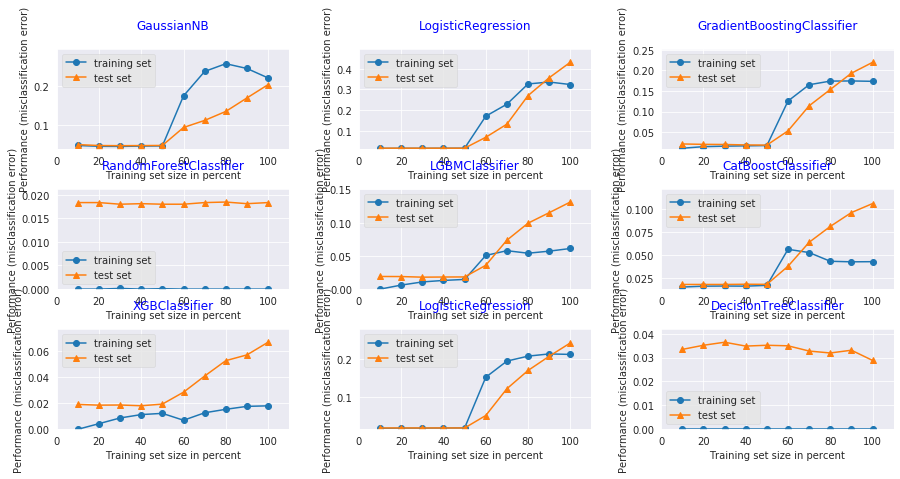

In [34]:
Trainsize(classifiers_A,nameA, X_train, y_train,X_test,y_test,calibration=True)

In [35]:
def ks_statistic(six_classifiers,name, X_train, y_train,X_test,y_test,calibration=True):
    
    
    from matplotlib import rcParams      ## Robie odstęp na podtytuł
    rcParams['axes.titlepad'] = 20 
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve
    import scikitplot as skplt
    import time
    start_time = time.time()
    
    plt.figure(figsize=(15,10))
    grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.5)

    for cls in six_classifiers:
        cls.fit(X_train, y_train)

    for i in range(9):

        col, row = i%3,i//3
        ax = plt.subplot(grid[row,col]) 
        ax.title.set_color('blue')

        model = six_classifiers[i]
        # skplt.metrics.plot_roc(y_test, model.predict_proba(X_test), ax=ax, title=type(six_classifiers[i]).__name__)
        skplt.metrics.plot_ks_statistic(y_test, model.predict_proba(X_test), ax=ax,title=type(six_classifiers[i]).__name__)
        ax.text(0.5, 1.04, name[i],fontsize=10)    ## podtytuł
        ax.text(0.0, 1.04, 'before calibration',color='black', fontsize=10)
### ---------------------------------------------------
    
    if calibration != True:
        print()
    else:   
    
    
        plt.figure(figsize=(15,10))
        grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.5)

        for cls in six_classifiers:
            cls.fit(X_train, y_train)

        for i in range(9):

            col, row = i%3,i//3
            ax = plt.subplot(grid[row,col]) 
            ax.title.set_color('blue')

       
            model = six_classifiers[i]
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
            calibrated.fit(X_train, y_train)         
        
            skplt.metrics.plot_ks_statistic(y_test, calibrated.predict_proba(X_test), ax=ax,title=type(six_classifiers[i]).__name__)
            ax.text(0.5, 1.04, name[i],fontsize=10)    ## podtytuł
            ax.text(0.0, 1.04, 'after calibration',color='red', fontsize=10)    ## podtytuł
    
    n = (time.time() - start_time)
    n = np.round(n)
    print('time: %s seconds' % n)       

time: 207.0 seconds


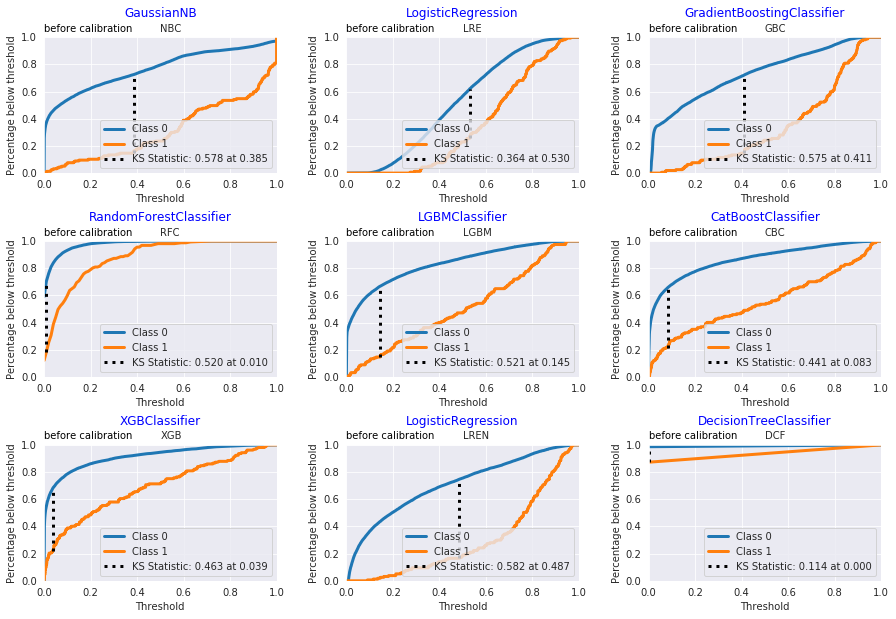

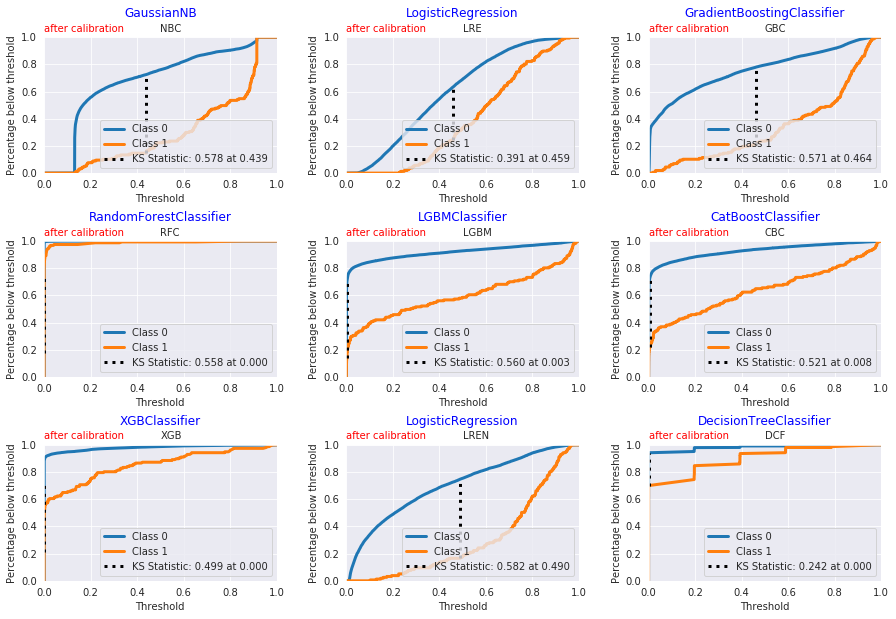

In [36]:
ks_statistic(classifiers_A,nameA, X_train, y_train,X_test,y_test,calibration=True)

In [37]:
def precision_recall2(six_classifiers,name, X_train, y_train,X_test,y_test):
    
    from sklearn.calibration import CalibratedClassifierCV, calibration_curve
    from matplotlib import rcParams      ## Robie odstęp na podtytuł
    rcParams['axes.titlepad'] = 20 
    import time
    start_time = time.time()
    
    import scikitplot as skplt
    
    plt.figure(figsize=(15,10))
    grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.5)

    for cls in six_classifiers:
        cls.fit(X_train, y_train)

    for i in range(9):

        col, row = i%3,i//3
        ax = plt.subplot(grid[row,col]) 
        ax.title.set_color('blue')

        model = six_classifiers[i]

        skplt.metrics.plot_precision_recall(y_test, model.predict_proba(X_test), ax=ax,title=type(six_classifiers[i]).__name__)
        ax.text(0.5, 1.09, name[i],fontsize=10)    ## podtytuł
        ax.text(0.0, 1.04, 'before calibration',color='black', fontsize=10)
### ---------------------------------------------------------------------

    plt.figure(figsize=(15,10))
    grid = plt.GridSpec(3, 3, wspace=0.3, hspace=0.5)

    for cls in six_classifiers:
        cls.fit(X_train, y_train)

    for i in range(9):

        col, row = i%3,i//3
        ax = plt.subplot(grid[row,col]) 
        ax.title.set_color('blue')

        model = six_classifiers[i]
        calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
        calibrated.fit(X_train, y_train)         

        skplt.metrics.plot_precision_recall(y_test, calibrated.predict_proba(X_test), ax=ax,title=type(six_classifiers[i]).__name__)
        ax.text(0.5, 1.09, name[i],fontsize=10)    ## podtytuł
        ax.text(0.0, 1.04, 'after calibration',color='red', fontsize=10)    ## podtytuł

    n = (time.time() - start_time)
    n = np.round(n)
    print('time: %s seconds' % n)     
    print(blue('Jest to krzywa łącząca precyzję (PPV) i Recall (TPR) na jednym wykresie. Im wyższa krzywa na osi y, tym lepsza wydajność modelu. Informuje, przy którym recall, precision zaczyna spadać, może pomóc wybrać próg'))

time: 207.0 seconds
Jest to krzywa łącząca precyzję (PPV) i Recall (TPR) na jednym wykresie. Im wyższa krzywa na osi y, tym lepsza wydajność modelu. Informuje, przy którym recall, precision zaczyna spadać, może pomóc wybrać próg


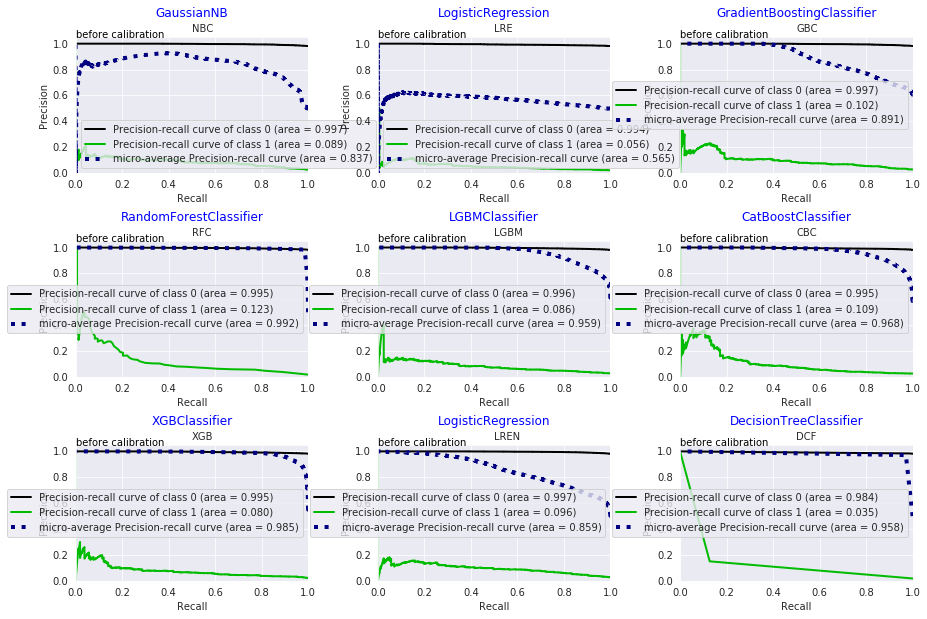

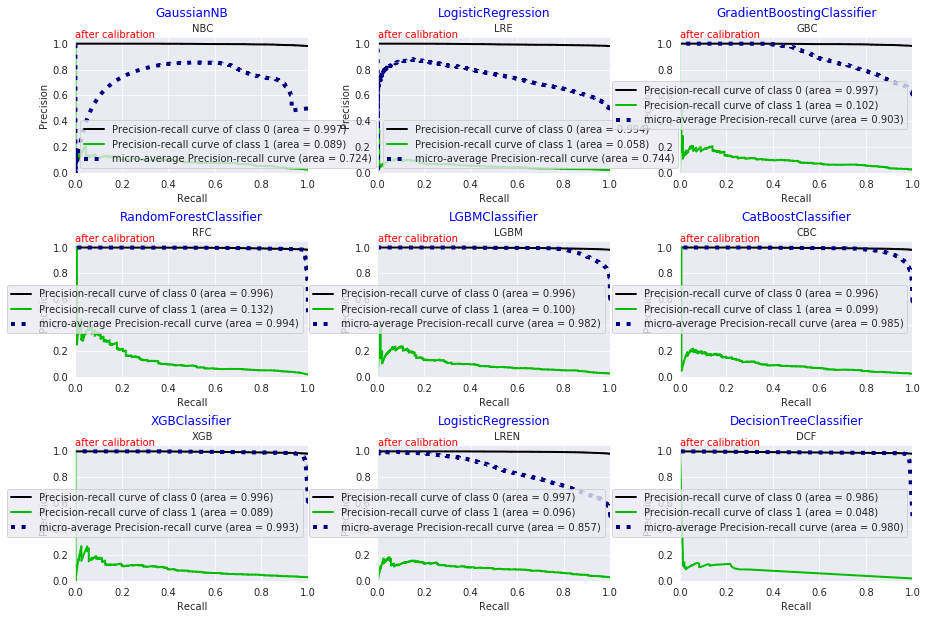

In [38]:
precision_recall2(classifiers_A,nameA, X_train, y_train,X_test,y_test)

Jak widac na wykresach problemem jest precyzjia klasy 1. Nie pomogła w tym zbilansowanie zbiorów przez oversampling.

https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html

In [39]:
def cumulative_gain(six_classifiers,name, X_train, y_train,X_test,y_test):

    from matplotlib import rcParams      ## Robie odstęp na podtytuł
    rcParams['axes.titlepad'] = 20     
    
    import scikitplot as skplt
    
    plt.figure(figsize=(15,7))
    grid = plt.GridSpec(2, 3, wspace=0.3, hspace=0.5)

    for cls in six_classifiers:
        cls.fit(X_train, y_train)

    for i in range(6):

        col, row = i%3,i//3
        ax = plt.subplot(grid[row,col]) 
        ax.title.set_color('blue')

        model = six_classifiers[i]

        skplt.metrics.plot_cumulative_gain(y_test, model.predict_proba(X_test), ax=ax,title=type(six_classifiers[i]).__name__)
        ax.text(0.5, 1.04, name[i],fontsize=10)    ## podtytuł
        
    plt.show()

In [40]:
def lift_curve(six_classifiers,name, X_train, y_train,X_test,y_test):
                
    import scikitplot as skplt
    
    plt.figure(figsize=(15,7))
    grid = plt.GridSpec(2, 3, wspace=0.3, hspace=0.5)

    for cls in six_classifiers:
        cls.fit(X_train, y_train)

    for i in range(6):

        col, row = i%3,i//3
        ax = plt.subplot(grid[row,col]) 
        ax.title.set_color('blue')

        model = six_classifiers[i]

        skplt.metrics.plot_lift_curve(y_test, model.predict_proba(X_test), ax=ax,title=type(six_classifiers[i]).__name__)
        ax.text(0.5, 8.04, name[i],fontsize=12)    ## podtytuł
        
    plt.show()

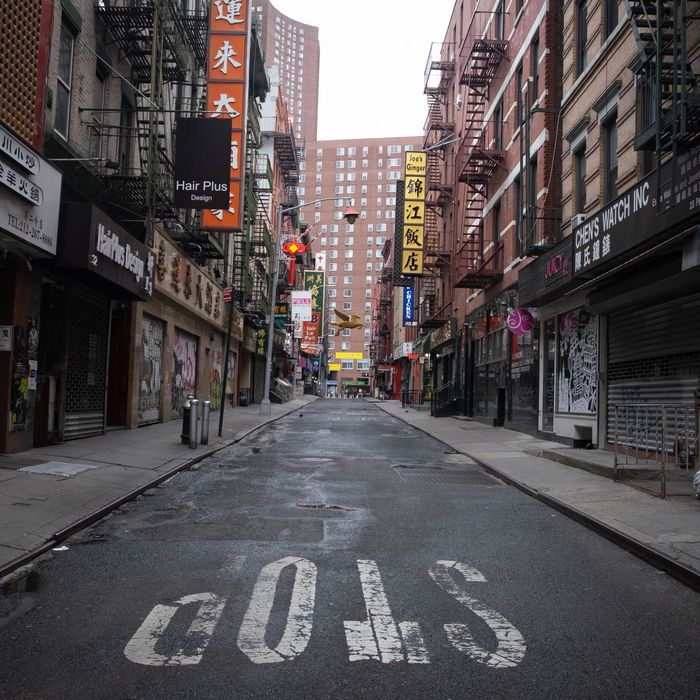